In [8]:
import pandas as pd
import numpy as np
np.seterr(all="raise")

{'divide': 'raise', 'over': 'raise', 'under': 'raise', 'invalid': 'raise'}

In [9]:
df = pd.read_parquet("out/2019-11-03-1d-train.parquet")
print(len(df))

df["h_nelement"] = df["h.shape[0]"]# * df["h.shape[1]"]
df["x_nelement"] = df["x.shape[0]"]# * df["x.shape[1]"]
df["log10(fft_time/direct_time)"] = np.log10(df.fft_time / df.direct_time)
df["log10(fft_time)"] = np.log10(df.fft_time)
df["log10(direct_time)"] = np.log10(df.direct_time)
df["fft_time/direct_time"] = df.fft_time / df.direct_time
df.tail()

2850


,fft_time,direct_time,mode,x.shape[0],h.shape[0],random_state,h_nelement,x_nelement,log10(fft_time/direct_time),log10(fft_time),log10(direct_time),fft_time/direct_time
2845,0.000841,1.662685,same,4124,49238,2845,49238,4124,-3.295896,-3.075087,0.220810,0.000506
2846,0.000847,0.057928,full,4124,58780,2846,58780,4124,-1.835192,-3.072302,-1.237110,0.014615
2847,0.000761,0.055093,valid,4124,58780,2847,58780,4124,-1.859770,-3.118673,-1.258903,0.013811
2848,0.000841,1.955389,same,4124,58780,2848,58780,4124,-3.366439,-3.075206,0.291233,0.000430
2849,0.001023,0.069160,full,4124,70170,2849,70170,4124,-1.830003,-2.990146,-1.160143,0.014791


In [10]:
df.fft_time.max()

0.003330623000010746

In [11]:
df.direct_time.max()

2.741176665000239

# Visualize ratio

Text(0.5, 1, 'valid')

Text(0.5, 1, 'same')

Text(0.5, 1, 'full')

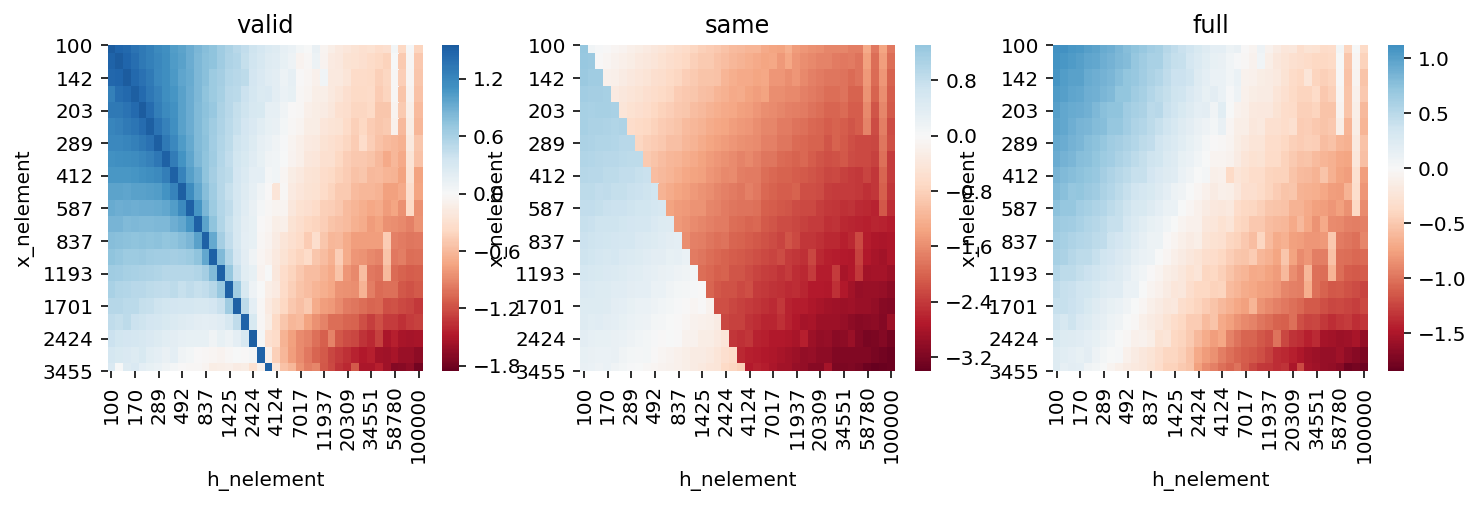

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

w = 3
fig, axs = plt.subplots(ncols=3, figsize=(4 * w, w))
for ax, mode in zip(axs, ["valid", "same", "full"]):
    idx = df["mode"] == mode
    if not idx.sum():
        continue
    show = df[df["mode"] == mode].pivot_table(
        index="x_nelement",
        columns="h_nelement",
        values="log10(fft_time/direct_time)",
    )
    ax = sns.heatmap(
        show,
        center=0,
        ax=ax,
        cmap="RdBu",
    )
    ax.set_title(mode)

# Find big-O constant

``` python
fft, direct = times(O_fft, O_direct)
method = "fft" if fft * O_fft < direct * O_direct else "direct"
```

Use torch to code custom loss function.


In [18]:
from scipy.optimize import curve_fit
from toolz import partial
sum_builtin = sum

def _prod(iterable):
    """
    Product of a list of numbers.
    Faster than np.prod for short lists like array shapes.
    """
    product = 1
    for x in iterable:
        product *= x
    return product

def _fftconv_faster(x_shape, x_size, h_shape, h_size, mode):
    """
    See if using fftconvolve or convolve is faster. The value returned (a
    boolean) depends on the sizes and shapes of the input values.
    The big O ratios were found to hold to different machines, which makes
    sense as it's the ratio that matters (the effective speed of the computer
    is found in both big O constants). Regardless, this had been tuned on an
    early 2015 MacBook Pro with 8GB RAM and an Intel i5 processor.
    """
    if mode == 'full':
        out_shape = [n + k - 1 for n, k in zip(x_shape, h_shape)]
    elif mode == 'same':
        out_shape = x_shape
    elif mode == 'valid':
        out_shape = [n - k + 1 for n, k in zip(x_shape, h_shape)]
    else:
        raise ValueError('mode is invalid')
    out_shape = [o if o > 0 else -o + 2 for o in out_shape]

    # see whether the Fourier transform convolution method or the direct
    # convolution method is faster (discussed in scikit-image PR #1792)
    direct_time = (x_size * h_size * _prod(out_shape))
    fft_time = sum_builtin(n * np.log(n) for n in (x_shape + h_shape +
                                               tuple(out_shape)))
    return fft_time, direct_time
    
def log_time(shapes, O, mode):
# def _fftconv_faster(shapes, O, mode):
    """
    See if using fftconvolve or convolve is faster. The value returned (a
    boolean) depends on the sizes and shapes of the input values.
    The big O ratios were found to hold to different machines, which makes
    sense as it's the ratio that matters (the effective speed of the computer
    is found in both big O constants). Regardless, this had been tuned on an
    early 2015 MacBook Pro with 8GB RAM and an Intel i5 processor.
    """
    times = []
    for shape in shapes:
        x_shape = np.array([shape[0]])
        h_shape = np.array([shape[1]])
        assert len(shape) == 2
        assert len(x_shape) == len(h_shape) == 1
        fft_time, direct_time = _fftconv_faster(
            x_shape, _prod(x_shape), h_shape, _prod(h_shape), mode,
        )
        times.append([fft_time, direct_time])
    times = np.asarray(times)
    fft_time = times[:, 0]
    direct_time = times[:, 1]
    diff = O * fft_time / direct_time
    
    power = np.log10(abs(diff))
    sign = np.sign(diff)
    return sign * power

def get_constant(df, mode):
    """
    Inputs
    ------
    df : DataFrame with columns x.shape[0], x.shape[1], h.shape[0], h.shape[1] and log10(fft_time/direct_time)
    
    Returns
    -------
    popt : float
        The constant such that constant * fft_time < direct_time
    pstd : float
        The (estimated) standard deviation of popt
    """
    shapes = df[["x.shape[0]", "h.shape[0]"]].values
    times = df["log10(fft_time/direct_time)"].values
    log_time_w_mode = partial(log_time, mode=mode)

#     p0s = {"full": 9e3, "same": 34e3, "valid": 66e3}
#     kwargs = {"p0": 2 * p0s[mode]}
#     kwargs = {"p0": 10e3}
    kwargs = {}
    popt, pcov = curve_fit(log_time_w_mode, shapes, times, **kwargs)
    O = popt.item()
    times_hat = log_time_w_mode(shapes, O)
    return O, np.sqrt(pcov).item(), (times_hat, times)

In [19]:
bigOs = {}
for mode in ["same", "valid", "full"]:
    idx = df["mode"] == mode
    if not idx.sum():
        continue
    fit = df[idx].copy()
    O, std, times = get_constant(fit, mode)
    y_hat, y = times
    fit["predicted_ratio"] = y_hat
    print(mode, O, std)
    bigOs[mode] = {"constant": O, "std": std}


same 964.3580370814427 80.34687428637622
valid 70921.51829900651 2306.147242849512
full 67425.80805326015 1704.2220648288737


In [20]:
constants = pd.DataFrame(bigOs).T
constants["ndim"] = 1

In [21]:
constants.index.name = "mode"
constants

,constant,std,ndim
mode,,,
same,964.358037,80.346874,1
valid,70921.518299,2306.147243,1
full,67425.808053,1704.222065,1


In [22]:
constants["std"] / constants["constant"]

mode
same     0.083316
valid    0.032517
full     0.025276
dtype: float64

In [23]:
constants.to_csv("constants.csv")